In [49]:
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

# Easy Interoir Point Optimizer

Here we want to program a short and easy-to-understand "Interior Point Optimizer" for non-linear optimization problems.
Consider the following non-linear optimization problem with equality constraints $\bm{h}(\bm{x}) = 0$ and inequality constraints $\bm{g}(\bm{x}) \leq 0$.

$
\begin{equation}
    \begin{aligned}
        \textrm{min} \quad &f(\bm{x}) = x_0^4 + x_1^4 \\
        \textrm{s. t.} \quad &\bm{h}(\bm{x}) = 2x_0-x_1 = 0 \\
        &\bm{g}(\bm{x}) \leq 0
    \end{aligned}
\end{equation}
$

In [50]:
# define programm
x = cas.SX.sym("x", 2)  # symbolic variable x
# objective function
f = x[0]**4 + x[1]**4
f_func = cas.Function(
    "f_function",
    [x],
    [f]
)
# equality constraints
h = 2*x[0] - x[1]
h_func = cas.Function(
    "eq_constraints",
    [x],
    [h]
)

### Derive KKT-Matrix

In [51]:
# calculate derivatives
d2f = cas.hessian(f, x)
d2f_func = cas.Function(
    "function_hessian",
    [x],
    [d2f[0]]
)
d2h = cas.hessian(h, x)
d2h_func = cas.Function(
    "equality_constraints_hessian",
    [x],
    [d2h[0]]
)
dh = cas.jacobian(h, x)
dh_func = cas.Function(
    "equality_constraints_jacobian",
    [x],
    [dh]
)
df = cas.jacobian(f, x)
df_func = cas.Function(
    "function_jacobian",
    [x],
    [df]
)

In [54]:
x_N = np.array([[50, 100]])
nu_N = np.array([[1]]) #  how to choose the first nu ??
tol = 1e-6  # optimization tolerance to break the loop
max_iter = 1000  # maximum iterations
n_iter = 0

for k in range(max_iter):
    x_current = x_N[k]
    # evaluate function derivatives
    d2f_eval = d2f_func(x_current); df_eval = df_func(x_current)
    # evaluate derivatives of constraints
    d2h_eval = d2h_func(x_current); dh_eval = dh_func(x_current)

    # create KKT-Matrix
    KKT = cas.horzcat(d2f_eval + d2h_eval.T * nu_N[k], dh_eval.T)  # first row of matrix

    zeros = np.array([0])
    sec_row = cas.horzcat(dh_eval, zeros)  # second row of matrix
    KKT = cas.vertcat(KKT, sec_row)

    # create vector b
    b = - cas.vertcat(df_eval.T, h_func(x_current))

    # solve linear system of equations with numpy because we really like numpy
    step = np.linalg.solve(
        a=KKT.full(),
        b=b.full()
    )
    x_next = x_current + step[:x.shape[0]].T
    nu_next = step[x.shape[0]:].T
    x_N = np.concatenate([x_N, x_next])
    nu_N = np.concatenate([nu_N, nu_next])
    n_iter += 1
    if np.abs(np.linalg.norm(x_N[k]) - np.linalg.norm(x_N[k-1])) <= tol:
        break

print("Optimization finished with", n_iter, "iterations.")
print("Optimal solution found at", x_N[-1])

Optimization finished with 45 iterations.
Optimal solution found at [5.95474745e-07 1.19094949e-06]


### Plot the results

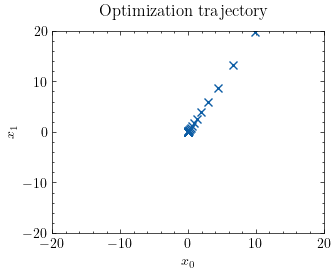

In [57]:
plt.rcParams["figure.figsize"] = (10,6)
plt.style.use('science')
fig, ax = plt.subplots(1)
fig.suptitle("Optimization trajectory")

ax.plot(x_N.T[0], x_N.T[1], "x")
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.axis([-20,20,-20,20])

# color grid
x_grid = y_grid = np.arange(-20, 20, 0.5)
grid = np.meshgrid(x_grid, y_grid)